<a href="https://colab.research.google.com/github/SydneySmoothvile/tremor/blob/main/TremorModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.model_selection
from sklearn import feature_selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import os
import subprocess
import math
import statistics
import numpy as np
import io
import pickle
import pprint
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
import sklearn.linear_model as lm
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [2]:
PATH = "/content/drive/MyDrive/Tremor Analysis"
os.chdir(PATH)

In [3]:
num_tremor_types = 4 #i.e. number of tremor categories is 4 for PD, ET, DT and controls respectively

#fix random seed for reproducibility of random number generator
seed = 7
np.random.seed(seed)

In [4]:
#ROC AUC - function used to generate area under the curve of ROC, using inputs of predicted vs. correct category
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

#one-hot encoding: convert data representation to one-hot encoding, which is required for inputs to train machine learning classifiers in Scikit-learn
def to_one_hot(labels, dimension):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label-1] = 1.
    return results

In [5]:
'''
The following array 'covars' contains the list of variables to be used as features for training the machine learning classifiers
- using kinetic and rest variables alone yielded the best classification results (i.e. 'KIN + REST' covars below)

'''

covars = ['RPC_X_kin','RPC_Y_kin','RPC_Z_kin','RPC_U_kin',
          'RPC_X_rest','RPC_Y_rest','RPC_Z_rest','RPC_U_rest','TSI_kin','TSI_amplitude_kin',
          'Mean_Peak_Amplitude_kin','Stddev_Peak_Amplitude_kin','TSI_rest','TSI_amplitude_rest',
          'Mean_Peak_Amplitude_rest','Stddev_Peak_Amplitude_rest']

#List of all features computed on accelerometer data, including those not used as training features
all_covars = ['Mean Inst. Freq_bat','TSI_bat','TSI_amplitude_bat','Mean Peak Amplitude_bat',
              'Stddev Peak Amplitude_+bat','TSI_amplitude to MeanPeakAmplitude ratio_bat',
              'StddevPeakAmplitude to MeanPeakAmplitude ratio_bat','Peak Freq_X_bat',
              'Peak Freq_Y_bat','Peak Freq_Z_bat','Peak Freq_U_bat','Peak Power_X_bat',
              'Peak Power_Y_bat','Peak Power_Z_bat','Peak Power_U_bat','RPC_X_bat','RPC_Y_bat',
              'RPC_Z_bat','RPC_U_bat','Mean Inst. Freq_kin','TSI_kin','TSI_amplitude_kin',
              'Mean_Peak_Amplitude_kin','Stddev_Peak_Amplitude_kin','TSI_amplitude to MeanPeakAmplitude ratio_kin',
              'StddevPeakAmplitude to MeanPeakAmplitude ratio_kin','Peak Freq_X_kin','Peak Freq_Y_kin','Peak Freq_Z_kin','Peak Freq_U_kin','Peak Power_X_kin','Peak Power_Y_kin','Peak Power_Z_kin','Peak Power_U_kin','RPC_X_kin','RPC_Y_kin','RPC_Z_kin','RPC_U_kin','Mean Inst. Freq_out','TSI_out','TSI_amplitude_out','Mean Peak Amplitude_out','Stddev Peak Amplitude_+out','TSI_amplitude to MeanPeakAmplitude ratio_out','StddevPeakAmplitude to MeanPeakAmplitude ratio_out','Peak Freq_X_out','Peak Freq_Y_out','Peak Freq_Z_out','Peak Freq_U_out','Peak Power_X_out','Peak Power_Y_out','Peak Power_Z_out','Peak Power_U_out','RPC_X_out','RPC_Y_out','RPC_Z_out','RPC_U_out','Mean Inst. Freq_rest','TSI_rest','TSI_amplitude_rest','Mean_Peak_Amplitude_rest','Stddev_Peak_Amplitude_rest','TSI_amplitude to MeanPeakAmplitude ratio_rest','StddevPeakAmplitude to MeanPeakAmplitude ratio_rest','Peak Freq_X_rest','Peak Freq_Y_rest','Peak Freq_Z_rest','Peak Freq_U_rest','Peak Power_X_rest','Peak Power_Y_rest','Peak Power_Z_rest','Peak Power_U_rest','RPC_X_rest','RPC_Y_rest','RPC_Z_rest','RPC_U_rest','RE_bat','RE_out']
			
#Data sets:
controls = False #If controls is True, trains classifiers including control data. If False, controls not included in analysis

featureSelection = False 

In [6]:
binaryClass = 'PD'
if binaryClass=='PD':
    if controls == True:
        #below file: Controls and other non-PD added into analysis as 'non-PD'
        df_totalData = pd.read_csv('AllAnalysisData_training_PDvsnon-PD_+controlsOnly.csv', index_col=False)
    else:
        df_totalData = pd.read_csv('AllAnalysisData_training_PDvsnon-PD.csv', index_col=False)
elif binaryClass=='ET':					
	df_totalData = pd.read_csv('AllAnalysisData_training_ETvsnon-ET.csv', index_col=False)
elif binaryClass=='DT':	
        df_totalData = pd.read_csv('AllAnalysisData_training_DTvsnon-DT.csv', index_col=False)
elif binaryClass=='PDET':
    df_totalData = pd.read_csv('AllAnalysisData_training_PDvsET.csv', index_col=False)
elif binaryClass=='sameAsClinical':
    df_totalData = pd.read_csv('AllAnalysisData_training_sameAsClinical.csv', index_col=False)
elif binaryClass=='sameAsClinical_PD':
    df_totalData = pd.read_csv('AllAnalysisData_training_sameAsClinical_PDvsnonPD.csv', index_col=False)
elif binaryClass=='sameAsClinical_ET':
    df_totalData = pd.read_csv('AllAnalysisData_training_sameAsClinical_ETvsnonET.csv', index_col=False)
elif binaryClass=='sameAsClinical+clinicalVars':
    df_totalData = pd.read_csv('AllAnalysisData_training_sameAsClinical_+clinicalVars.csv', index_col=False)

    '''
    - Various combinations of training features (i.e. covars) can be selected below by uncommenting
    - By default, KIN+REST accelerometer variables with the size siginficant clinical features is selected below
    '''
    
    #KIN + REST ONLY
    covars = ['Upper body','Bradykinesia (R+L)','BFMDRS','Sniffing sticks (below 8 pathological, up to 12)','Spiral density (averaged R and L)','Asymmetry dominant-nondominant','RPC_X_kin','RPC_Y_kin','RPC_Z_kin','RPC_U_kin','RPC_X_rest','RPC_Y_rest','RPC_Z_rest','RPC_U_rest','TSI_kin','TSI_amplitude_kin','Mean Peak Amplitude_kin','Stddev Peak Amplitude_+kin','TSI_rest','TSI_amplitude_rest','Mean Peak Amplitude_rest','Stddev Peak Amplitude_+rest']
    

else:
    if controls == False:
        #Trinary classification:
        df_totalData = pd.read_csv('AllAnalysisData_training1.csv', index_col=False)
    else:
        #Quarternary classification (i.e. including controls):
        df_totalData = pd.read_csv('AllAnalysisData_training1_+controlsOnly.csv', index_col=False)


'''
- The columns from the input text file corresponding to the features selected to be used in 'covars' are obtained below
- All features are then normalized on a scale between -1 and 1 below
'''
df_totalData.reindex(np.random.permutation(df_totalData.index))
df_x_train = df_totalData[covars]
df_x_train_allCovars = df_totalData[all_covars] #full dataset w/ all features, used later for finding best features
df_y_train = df_totalData[['Diagnosis_num']]
names = np.array(df_totalData[['Name']])

# sc = MinMaxScaler(feature_range=(0, 1))
# X_scaled = sc.fit_transform(X)

# log_model = LogisticRegression(C=1)
# log_model.fit(X_scaled, y)

# pickle.dump(log_model, open("ml_model.sav", "wb"))
# pickle.dump(sc, open("scaler.sav", "wb"))

scaler = RobustScaler() #scale data to normalize
df_x_train = scaler.fit_transform(df_x_train)

#The code commented below can be used to save the trained classifier in a file
        #model_file = open('tremor_classifier_model.joblib','wb')
        #pickle.dump(clf, model_file)
        #clf2 = pickle.load(open('tremor_classifier_model.joblib','rb')) 
#pickle.dump(scaler, open("scaler.sav", "wb"))

df_x_train = pd.DataFrame(df_x_train, columns=covars)
x_all = df_x_train.values

#Full dataset w/ all features, used later for finding best features
df_x_train_allCovars = scaler.fit_transform(df_x_train_allCovars)
df_x_train_allCovars = pd.DataFrame(df_x_train_allCovars, columns=all_covars)
x_allCovars = df_x_train_allCovars.values

In [7]:
df_x_train

,RPC_X_kin,RPC_Y_kin,RPC_Z_kin,RPC_U_kin,RPC_X_rest,RPC_Y_rest,RPC_Z_rest,RPC_U_rest,TSI_kin,TSI_amplitude_kin,Mean_Peak_Amplitude_kin,Stddev_Peak_Amplitude_kin,TSI_rest,TSI_amplitude_rest,Mean_Peak_Amplitude_rest,Stddev_Peak_Amplitude_rest
0,0.146997,0.423638,0.929020,1.010063,0.121500,0.555463,0.519084,0.244533,0.404367,0.362827,0.308266,0.434627,-1.304146,-0.146729,0.360347,-0.143508
1,-0.220857,-0.191469,-0.216758,-0.343112,-0.525690,-0.368919,-0.251282,-0.640041,0.093074,0.600461,0.653397,0.467582,0.906350,-0.254623,-0.233420,-0.244900
2,0.348859,-1.119078,-0.185360,0.151064,-1.030774,-1.035310,-1.022858,-1.007446,-0.228206,0.342429,0.462319,0.356822,-0.000114,-0.177975,-0.171739,-0.201537
3,-0.767443,-0.761401,-0.230098,-0.498660,-0.397874,-0.449216,0.348129,-0.134349,-0.192551,-0.577885,-0.537296,-0.743463,0.688257,0.137935,0.203752,0.016035
4,-0.495812,-0.976303,-0.594876,-0.133266,-0.175764,-0.108785,0.667491,0.038290,1.224125,-0.041506,-0.202473,-0.089639,-0.305636,-0.087159,-0.024146,-0.124113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,-0.338077,-1.272710,-0.653542,-0.318448,-1.331865,-1.038543,-0.960188,-1.288883,0.276284,1.021902,0.502667,1.147639,0.674708,-0.208087,-0.200002,0.040328
74,-0.017220,0.148453,0.214125,0.127963,-0.388103,-0.214689,-0.194154,-0.297727,1.274797,-0.744262,-0.639822,-0.844156,1.470260,-0.007929,-0.166357,0.085680
75,0.757370,0.243546,-0.190326,0.588242,0.000000,0.679320,-0.167166,-0.065286,-0.476487,-0.750341,-0.541949,-0.835464,0.550364,-0.267114,-0.233822,-0.222778
76,-0.008249,-0.196523,0.029132,0.103432,-0.399859,-0.289710,-0.950755,-0.465539,0.382851,-0.379464,-0.210141,-0.357399,0.333211,0.180515,0.116167,0.148195


In [8]:
df_y_train

,Diagnosis_num
0,0
1,1
2,1
3,1
4,1
...,...
73,1
74,0
75,1
76,1


In [9]:
x_all

array([[ 0.14699692,  0.42363801,  0.9290195 , ..., -0.14672854,
         0.36034656, -0.14350803],
       [-0.22085675, -0.19146881, -0.2167575 , ..., -0.25462261,
        -0.23342008, -0.24490019],
       [ 0.34885864, -1.11907846, -0.18536029, ..., -0.17797467,
        -0.17173919, -0.20153688],
       ...,
       [ 0.75737023,  0.24354557, -0.19032649, ..., -0.26711438,
        -0.23382152, -0.22277812],
       [-0.00824856, -0.1965233 ,  0.02913228, ...,  0.18051458,
         0.11616726,  0.14819472],
       [-0.41181922, -0.82712354,  0.13453922, ...,  0.74453562,
         1.1640549 ,  0.57080524]])

In [10]:
#The training data is converted one-hot-encoded form, as required by the initiation functions for the machine learning classifiers 
y_all_labels_pre = df_y_train.values
y_all_labels_list = []
for y in y_all_labels_pre:
	y_all_labels_list.append(y[0])
y_all = to_one_hot(df_y_train.values,num_tremor_types)
y_all_labels = np.array(y_all_labels_list)#convert to nparray

x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x_all, y_all, test_size=0.3, random_state=0)

In [ ]:
y_all_labels_pre

In [ ]:
y_all

In [13]:
df_totalData

,Name,Date,Randomization,Diagnosis_num,Diagnosis (basic),Mean Inst. Freq_bat,TSI_bat,TSI_amplitude_bat,Mean Peak Amplitude_bat,Stddev Peak Amplitude_+bat,...,Harmonic Power_X_rest,Harmonic Power_Y_rest,Harmonic Power_Z_rest,Harmonic Power_U_rest,RPC_X_rest,RPC_Y_rest,RPC_Z_rest,RPC_U_rest,RE_bat,RE_out
0,JC,nov 3 2017,0.478087,0,PD,4.882812,0.001250,0.032820,0.060178,0.023562,...,0.0,0,0.0,0.0,0.474538,0.646947,0.626921,0.534246,0.873374,0.560437
1,DB,july 14 2017,0.362024,1,ET,5.078125,0.859271,0.024065,0.035681,0.017998,...,0.0,0,0.0,0.0,0.361014,0.466949,0.483537,0.370926,0.153763,0.156108
2,JR,oct 20 2017,0.974764,1,ET,4.443359,0.195392,0.048710,0.181135,0.051339,...,0.0,0,0.0,0.0,0.272417,0.337187,0.339927,0.303092,0.399852,0.708365
3,MS,july 14 2017,0.403899,1,ET,5.468750,0.003543,0.045701,0.171053,0.033300,...,0.0,0,0.0,0.0,0.383435,0.451313,0.595102,0.464293,0.530494,1.125352
4,SM,july 14 2017,0.377619,1,ET,6.445312,0.177003,0.157158,0.668466,0.133377,...,0.0,0,0.0,0.0,0.422395,0.517603,0.654543,0.496167,0.112704,0.349339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,NC,sept 29 2017,0.015020,1,Dystonic tremor,5.029297,0.861854,0.343970,0.313675,0.252267,...,0.0,0,0.0,0.0,0.219602,0.336558,0.351591,0.251130,0.115458,0.268034
74,WLS,july 20 2015,0.868824,0,PD,8.602151,2.418782,0.008692,0.012996,0.007072,...,0.0,0,0.0,0.0,0.385148,0.496981,0.494170,0.434128,0.999481,0.999536
75,EAS,july 7 2017,0.581684,1,ET,4.296875,0.779649,0.035348,0.057655,0.024560,...,0.0,0,0.0,0.0,0.453226,0.671065,0.499193,0.477044,0.229029,0.294316
76,RK,july 15 2016,0.884473,1,ET,6.640625,1.828192,0.032008,0.033063,0.044850,...,0.0,0,0.0,0.0,0.383086,0.482373,0.353347,0.403145,0.962517,0.955827


In [20]:
df_totalData.describe()

,Randomization,Diagnosis_num,Mean Inst. Freq_bat,TSI_bat,TSI_amplitude_bat,Mean Peak Amplitude_bat,Stddev Peak Amplitude_+bat,TSI_amplitude to MeanPeakAmplitude ratio_bat,StddevPeakAmplitude to MeanPeakAmplitude ratio_bat,Peak Freq_X_bat,...,Harmonic Power_X_rest,Harmonic Power_Y_rest,Harmonic Power_Z_rest,Harmonic Power_U_rest,RPC_X_rest,RPC_Y_rest,RPC_Z_rest,RPC_U_rest,RE_bat,RE_out
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.0,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.504066,0.756410,5.104622,0.951567,0.141543,0.275794,0.102176,0.584866,0.460707,5.233307,...,0.005055,0.0,0.008361,0.012444,0.448463,0.547765,0.522345,0.491380,0.679479,0.690683
std,0.290664,0.432026,1.066672,0.603212,0.252809,0.362452,0.151791,0.348671,0.248269,1.125063,...,0.022740,0.0,0.039395,0.049327,0.117384,0.129707,0.147616,0.126507,0.520425,0.400698
min,0.015020,0.000000,2.929688,0.001250,0.004232,0.007199,0.004287,0.125719,0.082764,2.800932,...,0.000000,0.0,0.000000,0.000000,0.215902,0.162897,0.130456,0.091435,0.036636,0.038613
25%,0.286687,1.000000,4.406738,0.557710,0.035348,0.057655,0.028981,0.308045,0.283724,4.458585,...,0.000000,0.0,0.000000,0.000000,0.366519,0.451914,0.440133,0.407297,0.289182,0.369089
50%,0.479390,1.000000,4.980469,0.856501,0.063685,0.162919,0.049442,0.531392,0.416635,5.078767,...,0.000000,0.0,0.000000,0.000000,0.453226,0.538786,0.530307,0.489097,0.539412,0.640596
75%,0.756460,1.000000,5.628790,1.331440,0.140784,0.320667,0.116509,0.775666,0.574092,5.671054,...,0.000000,0.0,0.000000,0.000000,0.541930,0.646637,0.626259,0.591927,0.999132,0.997713
max,0.985118,1.000000,8.691406,3.268467,1.734521,2.378663,1.101092,1.858903,1.356509,9.415089,...,0.134661,0.0,0.301123,0.354375,0.683378,0.774658,0.790099,0.731740,3.278631,2.134579


In [26]:
df_totalData.columns.values.tolist()

['Name',
 'Date',
 'Randomization',
 'Diagnosis_num',
 'Diagnosis (basic)',
 'Mean Inst. Freq_bat',
 'TSI_bat',
 'TSI_amplitude_bat',
 'Mean Peak Amplitude_bat',
 'Stddev Peak Amplitude_+bat',
 'TSI_amplitude to MeanPeakAmplitude ratio_bat',
 'StddevPeakAmplitude to MeanPeakAmplitude ratio_bat',
 'Peak Freq_X_bat',
 'Peak Freq_Y_bat',
 'Peak Freq_Z_bat',
 'Peak Freq_U_bat',
 'Peak Power_X_bat',
 'Peak Power_Y_bat',
 'Peak Power_Z_bat',
 'Peak Power_U_bat',
 'Harmonic Present_X_bat',
 'Harmonic Present_Y_bat',
 'Harmonic Present_Z_bat',
 'Harmonic Present_U_bat',
 'Harmonic Power_X_bat',
 'Harmonic Power_Y_bat',
 'Harmonic Power_Z_bat',
 'Harmonic Power_U_bat',
 'RPC_X_bat',
 'RPC_Y_bat',
 'RPC_Z_bat',
 'RPC_U_bat',
 'Mean Inst. Freq_kin',
 'TSI_kin',
 'TSI_amplitude_kin',
 'Mean_Peak_Amplitude_kin',
 'Stddev_Peak_Amplitude_kin',
 'TSI_amplitude to MeanPeakAmplitude ratio_kin',
 'StddevPeakAmplitude to MeanPeakAmplitude ratio_kin',
 'Peak Freq_X_kin',
 'Peak Freq_Y_kin',
 'Peak Freq_Z_k

In [21]:
df_totalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Columns: 115 entries, Name to RE_out
dtypes: float64(94), int64(18), object(3)
memory usage: 70.2+ KB


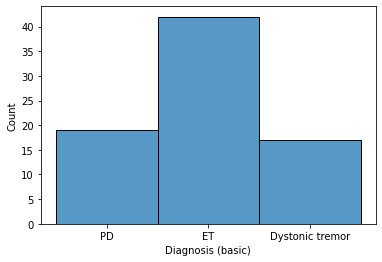

In [27]:
sns.histplot(df_totalData['Diagnosis (basic)'], bins=30)

In [28]:
df_totalData.shape

(78, 115)

In [14]:
#Define model:
num_inputs = len(covars) #number of features used
DT_num = 0
DT_num_pred = 0
DT_num_pred_cor = 0

In [15]:
covars

['RPC_X_kin',
 'RPC_Y_kin',
 'RPC_Z_kin',
 'RPC_U_kin',
 'RPC_X_rest',
 'RPC_Y_rest',
 'RPC_Z_rest',
 'RPC_U_rest',
 'TSI_kin',
 'TSI_amplitude_kin',
 'Mean_Peak_Amplitude_kin',
 'Stddev_Peak_Amplitude_kin',
 'TSI_rest',
 'TSI_amplitude_rest',
 'Mean_Peak_Amplitude_rest',
 'Stddev_Peak_Amplitude_rest']

In [16]:
num_inputs

16

In [19]:
y_all_labels.size

78

In [17]:
#Initiate K-fold Cross-Validation
num_split = y_all_labels.size #15
num_epochs = 150
cvscores = []
tot_cvscores = []
tot_val_acc = np.zeros(num_epochs)
if binaryClass:
	tot_con_matrix = [[0,0],[0,0]]
else:
	tot_con_matrix = [[0,0,0],[0,0,0],[0,0,0]]
Y_test_tot = []
y_pred_tot = []
y_pred = []

num_kcross_rand = 1
for i in range(num_kcross_rand):
    kfold = KFold(n_splits=num_split, shuffle=False)
    #LOOCV selected by default, next line can be uncommented to use other structures of KFCV
    #kfold = StratifiedKFold(n_splits=num_split, shuffle=True)# random_state=seed)
    cvscores.clear()

    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

    for train, test in kfold.split(np.zeros(y_all_labels.size), y_all_labels):
        model.fit(x_all[train],y_all_labels[train])
        clf = model.fit(x_all[train],y_all_labels[train])
        
        #The code commented below can be used to save the trained classifier in a file
        #model_file = open('tremor_classifier_model.joblib','wb')
        #pickle.dump(clf, model_file)
        #clf2 = pickle.load(open('tremor_classifier_model.joblib','rb')) 
        pred = clf.predict(x_all[test])
        scores = clf.score(x_all[test], y_all_labels[test])
        cvscores.append(scores * 100)
        tot_cvscores.append(scores * 100)
        y_pred.append(pred[0])
        print(names[test][0][0]+" - Actual: "+str(y_all_labels[test][0])+" - Pred: "+str(pred[0]))

'''
- Classification performance (including precision, recall and F1-score) and overall accuracy are outputted to the user in text form using the code below
- Confusion matrix showing the specific results is also shown
'''
print(classification_report(y_all_labels, y_pred))
print('Confusion Matrix')
con_matrix = confusion_matrix(y_all_labels, y_pred)
print(con_matrix)
print('Accuracy (Trinary): '+str(np.mean(cvscores)))


JC - Actual: 0 - Pred: 1
DB - Actual: 1 - Pred: 1
JR - Actual: 1 - Pred: 1
MS - Actual: 1 - Pred: 1
SM - Actual: 1 - Pred: 1
NH - Actual: 1 - Pred: 1
MG - Actual: 1 - Pred: 1
LRB - Actual: 1 - Pred: 1
G - Actual: 0 - Pred: 1
TR - Actual: 0 - Pred: 1
WG - Actual: 0 - Pred: 0
BC - Actual: 1 - Pred: 1
JM - Actual: 1 - Pred: 1
GM - Actual: 1 - Pred: 1
NJ - Actual: 0 - Pred: 0
AG - Actual: 1 - Pred: 1
CFZ - Actual: 1 - Pred: 1
L - Actual: 0 - Pred: 0
KS - Actual: 0 - Pred: 0
SB - Actual: 1 - Pred: 1
JT - Actual: 1 - Pred: 1
MAG - Actual: 1 - Pred: 1
EW - Actual: 1 - Pred: 1
JS - Actual: 1 - Pred: 1
MG - Actual: 0 - Pred: 0
ER - Actual: 1 - Pred: 1
JS - Actual: 1 - Pred: 1
JB - Actual: 1 - Pred: 1
RS - Actual: 0 - Pred: 0
AG - Actual: 0 - Pred: 0
DEC - Actual: 1 - Pred: 1
LSM - Actual: 1 - Pred: 1
SAS - Actual: 1 - Pred: 0
RRB - Actual: 1 - Pred: 1
GM - Actual: 1 - Pred: 1
RE - Actual: 1 - Pred: 1
KMJ - Actual: 1 - Pred: 1
DDF - Actual: 1 - Pred: 1
HFM - Actual: 1 - Pred: 0
MM - Actual: 1 - 

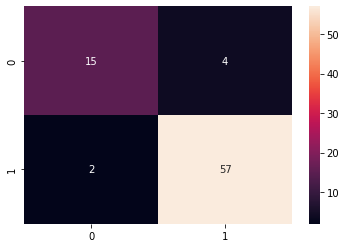

In [29]:
sns.heatmap(confusion_matrix(y_all_labels, y_pred), annot = True)

In [58]:
logit_auc_score = roc_auc_score(y_all_labels, y_pred)#generating AUC score
fpr, tpr, thresholds = roc_curve(y_all_labels,model.predict_proba(x_all[test])[:,1])
plt.figure(figsize = (15,5))
plt.title("Receiving Operating Characterist Curve")
plt.plot(fpr, tpr, 'g', label = "Log Reg (AUC = %0..2f) " % logit_auc_score)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 0.1])
plt.ylim([0.0, 0.1])
plt.xlabel("False Positivity Rate")
plt.ylabel("True Positivity Rate")
plt.legend(loc = "lower right")

ValueError: ignored

In [49]:
#ROC - computed for instances of binary classification, e.g. PD vs. non-PD
    if binaryClass != '' and binaryClass != 'sameAsClinical' and binaryClass != 'sameAsClinical+clinicalVars':
         # AUC = roc_auc_score(y_all_labels, y_pred)
          #print('AUC: '+str(AUC))
      
    if binaryClass=='' or binaryClass=='sameAsClinical' or binaryClass=='sameAsClinical+clinicalVars':
        #Convert to PD-nonPD
        y_all_labels_PD = []
        y_pred_PD = []
        for i in range(len(y_pred)):
            if y_all_labels[i] == 1:
                y_all_labels_PD.append(0)
            else:
                y_all_labels_PD.append(1)
            if y_pred[i] == 1:
                y_pred_PD.append(0)
            else:
                y_pred_PD.append(1)
        y_all_labels_PD = np.array(y_all_labels_PD)
        y_pred_PD = np.array(y_pred_PD)
        '''Display classification performance, confusion matrix showing results of classification, and AUC of the ROC (below)
        '''
        print('Converted to PD vs non-PD')
        print(classification_report(y_all_labels_PD, y_pred_PD))
        print('Confusion Matrix PD vs non-PD')
        con_matrix = confusion_matrix(y_all_labels_PD, y_pred_PD)
        print(con_matrix)
        AUC = roc_auc_score(y_all_labels_PD, y_pred_PD)
        print('AUC: '+str(AUC))
        print('Accuracy: '+str(accuracy_score(y_all_labels_PD, y_pred_PD)))
        
        
        #Convert to ET-nonET
        y_all_labels_ET = []
        y_pred_ET = []
        for i in range(len(y_pred)):
            if y_all_labels[i] == 2:
                y_all_labels_ET.append(0)
            else:
                y_all_labels_ET.append(1)
            if y_pred[i] == 2:
                y_pred_ET.append(0)
            else:
                y_pred_ET.append(1)
        y_all_labels_ET = np.array(y_all_labels_ET)
        y_pred_ET = np.array(y_pred_ET)
        print('Converted to ET vs non-ET')
        print(classification_report(y_all_labels_ET, y_pred_ET))
        print('Confusion Matrix ET vs non-ET')
        con_matrix = confusion_matrix(y_all_labels_ET, y_pred_ET)
        print(con_matrix)
        AUC = roc_auc_score(y_all_labels_ET, y_pred_ET)
        print('AUC: '+str(AUC))
        print('Accuracy: '+str(accuracy_score(y_all_labels_ET, y_pred_ET)))
        
        #Convert to DT-nonDT
        y_all_labels_DT = []
        y_pred_DT = []
        for i in range(len(y_pred)):
            if y_all_labels[i] == 3:
                y_all_labels_DT.append(0)
            else:
                y_all_labels_DT.append(1)
            if y_pred[i] == 3:
                y_pred_DT.append(0)
            else:
                y_pred_DT.append(1)
        y_all_labels_DT = np.array(y_all_labels_DT)
        y_pred_DT = np.array(y_pred_DT)
        print('Converted to DT vs non-DT')
        print(classification_report(y_all_labels_DT, y_pred_DT))
        print('Confusion Matrix DT vs non-DT')
        con_matrix = confusion_matrix(y_all_labels_DT, y_pred_DT)
        print(con_matrix)
        AUC = roc_auc_score(y_all_labels_DT, y_pred_DT)
        print('AUC: '+str(AUC))
        print('Accuracy: '+str(accuracy_score(y_all_labels_DT, y_pred_DT)))

IndentationError: ignored

In [ ]:
x_all[test]